In [4]:
using MLDatasets, Flux, LinearAlgebra, ProgressMeter, Zygote, ReverseDiff, CairoMakie
include("DenseNTK.jl"); include("FastNTKMethods.jl")

kernel (generic function with 3 methods)

In [3]:

function load_MNIST()
    """
    Loading the MNIST dataset.
    10 classes of digits from 0 to 9,
    each with 28x28 pixel dimensions.
    X: Grayscale vector, Y: Correct label.
    """

    X_training, Y_training = MNIST(split = :train)[:]
    X_testing, Y_testing = MNIST(split = :test)[:]
    X_training = Flux.flatten(X_training)
    X_testing = Flux.flatten(X_testing)
    Y_training = Flux.onehotbatch(Y_training, 0:9)
    Y_testing = Flux.onehotbatch(Y_testing, 0:9)
    return X_training, Y_training, X_testing, Y_testing
end

### MODELS
DenseNTKmodel = Chain(
  DenseNTK(28 * 28, 16, sigmoid),        # 784 x 16 + 16 = 12560 parameters
  DenseNTK(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  DenseNTK(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  DenseNTK(16, 10, sigmoid)              #  16 x 10 + 10 =   170 parameters
)  

model = Chain(
  Dense(28 * 28, 16, sigmoid),        # 784 x 16 + 16 = 12560 parameters
  Dense(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  Dense(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  Dense(16, 10, sigmoid)              #  16 x 10 + 10 =   170 parameters
)   

### DATA 
N=20
x = load_MNIST()[1][:,1:N];

In [17]:
K1 = kernel(DenseNTKmodel, x, true, 1);
K2 = kernel(DenseNTKmodel, x, true, 2);
K3 = kernel(DenseNTKmodel, x, true, 3);


ReverseDiff Jacobian: 0.192101 seconds (1.16 k allocations: 51.012 MiB, 5.70% gc time)
Kernel computation: 0.005482 seconds (3 allocations: 312.562 KiB)

ReverseDiff Jacobian: 0.270641 seconds (1.75 M allocations: 133.141 MiB, 5.82% gc time)
Kernel computation: 0.006317 seconds (3 allocations: 312.562 KiB)

Zygote Jacobian: 0.082525 seconds (27.07 k allocations: 166.320 MiB, 15.25% gc time)
Kernel computation: 0.007215 seconds (3 allocations: 312.562 KiB)


In [18]:
E1 = eigen(K1).values
E2 = eigen(K2).values
E3 = eigen(K3).values

println("Eigen values:")
hcat(E1, E2, E3)

Eigen values:


200×3 Matrix{Float64}:
 1.09861e-10  9.60773e-11  9.60773e-11
 1.81364e-10  1.58384e-10  1.58385e-10
 2.00628e-10  2.38927e-10  2.38928e-10
 2.87715e-10  2.66728e-10  2.66728e-10
 3.17734e-10  3.24002e-10  3.24002e-10
 3.57248e-10  3.62458e-10  3.62457e-10
 4.48197e-10  3.85257e-10  3.85256e-10
 4.92876e-10  4.03423e-10  4.03423e-10
 5.7026e-10   4.79449e-10  4.79449e-10
 6.77687e-10  4.86938e-10  4.86937e-10
 ⋮                         
 0.0119336    0.0119383    0.0119383
 0.0666494    0.066697     0.066697
 0.138379     0.138403     0.138403
 0.154279     0.154349     0.154349
 0.233498     0.233569     0.233569
 0.278384     0.278341     0.278341
 0.342066     0.342122     0.342122
 0.349386     0.349453     0.349453
 0.403336     0.403414     0.403414

In [154]:
#display(K1); display(K2); display(K3)

<h1>5% of MNIST</h1>

In [168]:
### DATA 
N=3000
x5 = load_MNIST()[1][:,1:N];

In [169]:
K1 = kernel(DenseNTKmodel, x5, true, 1);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46



ReverseDiff Jacobian: 45.041085 seconds (188.48 k allocations: 7.473 GiB, 36.03% gc time)
Kernel computation: 69.035340 seconds (3 allocations: 6.706 GiB, 0.00% gc time)


<h1>Performance breakdown</h1>

In [5]:
# Fake data
Nx=500
a=-1.0; b=1.0

xVec=hcat(collect(range(a,stop=b,length=Nx))...);
yVec=sin.(2*pi*xVec) .+ 0.1*randn(size(xVec));

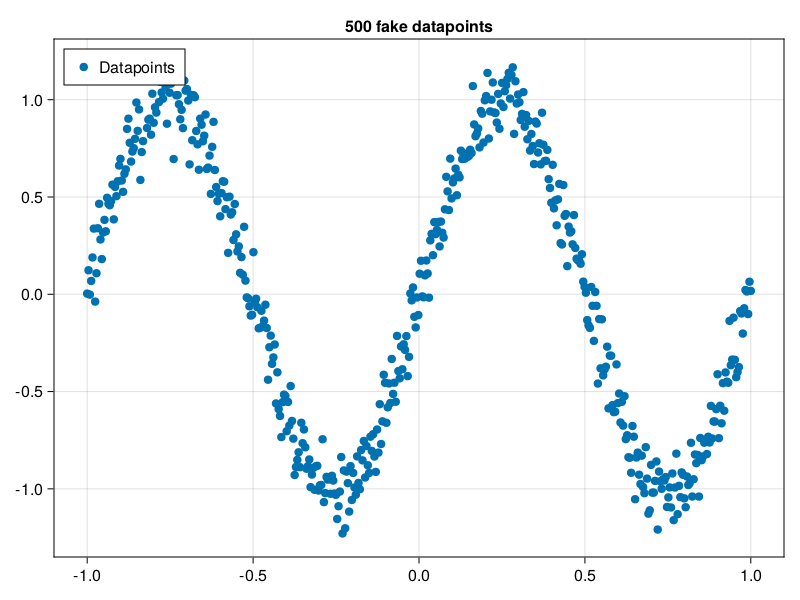

In [7]:
fig = Figure()
ax1 = Axis(fig[1,1], title="$Nx fake datapoints")
CairoMakie.scatter!(xVec[:], yVec[:], label="Datapoints")
axislegend(ax1,position=:lt)
fig

In [9]:
### MODELS
model = Chain(
  DenseNTK(1, 16, relu),   
  DenseNTK(16, 16, relu),  
  DenseNTK(16, 16, relu),  
  DenseNTK(16, 1)          
);

model(xVec)

1×500 Matrix{Float64}:
 -1.4874  -1.48847  -1.48955  -1.49063  …  -1.74493  -1.74458  -1.74423

In [13]:
runs = 100

K1 = []; K2 = []; K3 = [];

@showprogress for i = 1:runs
    model = Chain(
    DenseNTK(1, 16, relu),       
    DenseNTK(16, 16, relu),   
    DenseNTK(16, 16, relu),      
    DenseNTK(16, 1)              
    );

    push!(K1, kernel(model,xVec,false,1))
    push!(K2, kernel(model,xVec,false,2))
    push!(K3, kernel(model,xVec,false,3))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


In [14]:
E1 = []; E2 = []; E3 = [];

@showprogress for i = 1:runs
    push!(E1, eigen(K1[i]))
    push!(E2, eigen(K2[i]))
    push!(E3, eigen(K3[i]))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


100

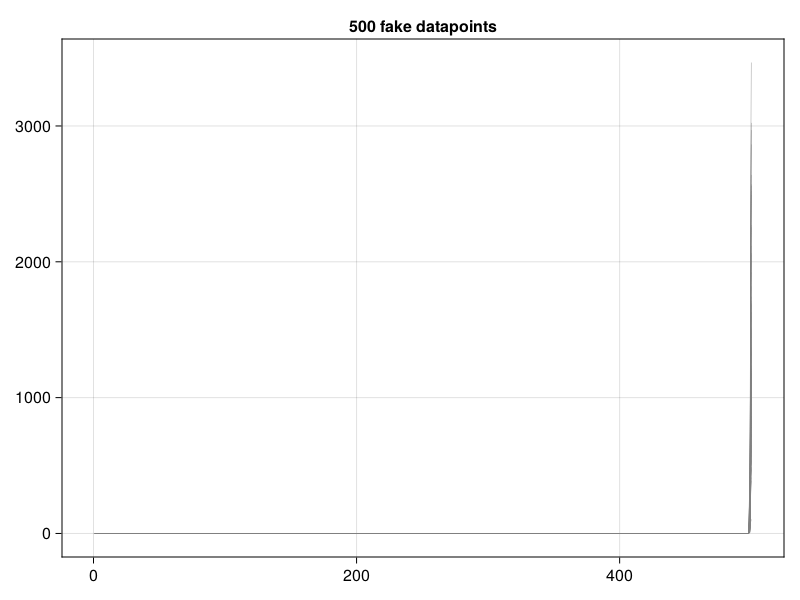

In [30]:
fig = Figure()
ax1 = Axis(fig[1,1], yscale=log10, title="$Nx fake datapoints")

for i = 1:length(E1)
    CairoMakie.lines!((abs.(E1[i].values))[:], color=:gray, linewidth=0.4)
end

display(length(E1))

fig